### End-to-End Pipeline Summary  

| Step | Module / Analysis                | What We Did                                                                 | Key Findings / Outcomes                                                                 |
|------|----------------------------------|------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| **1.1** | Data Loading & Class Balance      | Loaded `train_human.npy`, `train_ai.npy`; confirmed 8,161 per class          | Dataset balanced (50/50 Human vs AI)                                                     |
| **1.2** | Embedding Norms (L2)              | Computed mean L2 norms per sample & per token position                       | AI norms slightly higher (4.64 vs 4.25); AI shows stronger early-token “front-loading”   |
| **1.3** | PCA Projection (2D)               | Mean-pooled (100×768 → 768) → PCA → scatter plot                             | Human spread wider; AI compressed into cone-like cluster                                 |
| **1.4** | Cosine Similarity to Centroids    | Built class centroids & measured similarities                                | AI tightly clusters around its centroid; Humans more variable                            |
| **1.5** | Train vs Validation Norms/PCA     | Compared norms & PCA distributions between train and val                     | Validation closer to Humans but mixed; hints of AI-like noise                            |
| **1.6** | Embedding Variance (tokens/dims)  | Avg variance per token + per-dimension variance                              | AI > Human variance; Validation even higher; spikes at ~590+ dims (noisy channels)       |
| **2.1** | Maximum Mean Discrepancy (MMD)    | Kernel MMD between train vs val (mean-pooled)                                | Validation closer to Human distribution, but with AI-like traits                        |
| **2.2** | Cosine Heatmaps (Val→Centroids)   | Heatmap of val sample similarities to Human vs AI centroids                  | Majority align more with AI centroid; some closer to Human → supports pseudo-labeling    |
| **2.3** | Token-wise Decomposition          | Early / Mid / Late token norms                                               | AI strongly early-loaded; Humans more balanced; Val follows AI-like early emphasis       |
| **2.4** | Positional Entropy (Sharpness)    | Cosine distance spread per sample                                            | AI sharper (tokens closer to mean); Humans more diverse; Val partly omitted in plot      |
| **2.5** | UMAP (2D) Projection              | Nonlinear embedding of mean-pooled vectors                                   | AI & Human overlap heavily; Val sits between them, leaning Human-like                    |
| **2.6** | Cross-Class Similarity            | Cosine similarity between Human, AI, Val centroids                           | All high (>0.97); Val closer to Human (0.9968) than AI (0.9902)                          |
| **3.1** | t-SNE Projection (2D)             | Subsampled 500 each class; visualized with t-SNE                             | Partial Human vs AI separation; Validation mixed across both                            |
| **3.2** | UMAP (3D) Projection              | Mean-pooled → 3D UMAP                                                        | AI higher in UMAP-3 axis; Humans lower; Val in-between (closer to Humans)               |
| **3.3** | Logistic Regression on t-SNE      | Fit simple classifier on 2D t-SNE space                                      | Separation visible but noisy; training acc ~0.59; Val scattered                          |
| **3.4** | Balanced t-SNE Subset             | Equal 150 per class to reduce clutter                                        | Confirms overlap; Val spans both Human & AI zones                                        |
| **B**   | Engineered Features               | Variance masking, segment norms, token variance, sharpness cosine            | Designed interpretable tabular features to augment embeddings                           |
| **C**   | Centroids & Feature Build         | Stratified split; centroids (train only); feature scaling                    | Leak-free centroids & standardized features for hybrid models                           |
| **D**   | UltraHybrid-Balanced++ v2 Model   | Transformer + CNN + BiGRU + FeatureGate + DropPath + multi-sample dropout    | Robust hybrid learner combining deep + tabular paths                                    |
| **E**   | Training Utilities & Loop         | AdamW, OneCycleLR, BCEWithLogitsLoss, MixUp, early stopping (val AUC)        | Prevents overfitting; stable convergence; monitored metrics (AUC, F1, Prec, Rec, Acc)   |
| **F**   | Results (Epoch 12 best)           | Train AUC 0.9966, Acc 0.972, F1 0.973; Val AUC 0.9625, Acc 0.895, F1 0.898   | High recall (0.93) but lower precision (0.868); modest generalization gap               |
| **G**   | Improvements Considered           | Threshold tuning, calibration, ensembling, feature-gating tweaks             | To reduce false positives, sharpen calibration, and exploit multiple epochs              |
| **H**   | Test Inference & Submission       | Parse test JSONL → mask/features/scale → predict per-sentence → logit-mean   | Deterministic `submission_base_prob.csv` with schema [id, y_prob]                       |


#==========EDA

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np


# Load data
human_data = np.load('data/train/train_human.npy')  # shape: (N1, 100, 768)
ai_data = np.load('data/train/train_ai.npy')        # shape: (N2, 100, 768)

# Add labels
human_labels = np.zeros(len(human_data), dtype=int)
ai_labels = np.ones(len(ai_data), dtype=int)

# Combine
X = np.concatenate([human_data, ai_data], axis=0)
y = np.concatenate([human_labels, ai_labels], axis=0)
import json
import numpy as np

val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)

        if 'features' not in entry:
            continue
        
        feature_list = entry['features']
        
        for emb_array in feature_list:
            emb = np.array(emb_array)
            
            if emb.shape == (100, 768):
                val_embeddings.append(emb)
            else:
                print(f"Line {i}: skipped embedding of shape {emb.shape}")

print(f"Collected {len(val_embeddings)} usable embeddings.")

X_val = np.stack(val_embeddings)
print("X_val shape:", X_val.shape)  # Should be (N, 100, 768)

print(f"Total samples: {X.shape[0]}")
print(f"Each sample shape: {X.shape[1:]}")  # Should be (100, 768)


Collected 220 usable embeddings.
X_val shape: (220, 100, 768)
Total samples: 16322
Each sample shape: (100, 768)


#Embedding Norms
We’ll compute L2 norm of embeddings per sentence (mean over 100 tokens), then compare AI vs Human.

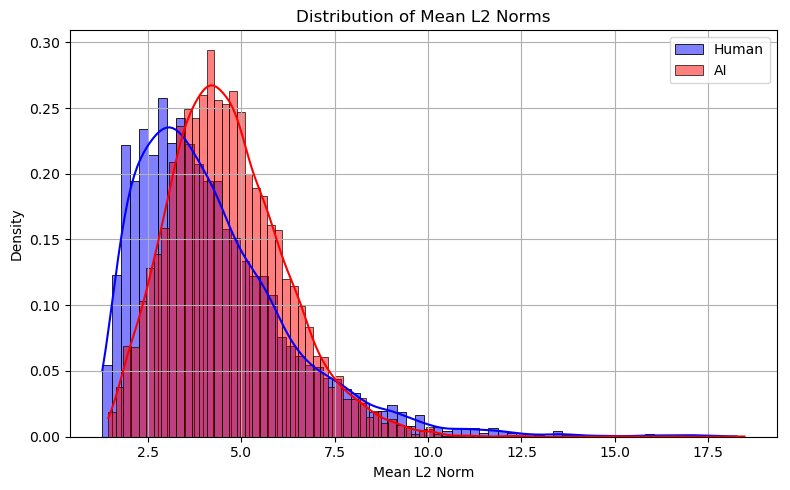

In [4]:
# Compute L2 norms per sample (mean over tokens)
norms = np.linalg.norm(X, axis=2)  # shape: (N, 100)
mean_norms = norms.mean(axis=1)    # shape: (N,)

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_norms[y == 0], color='blue', label='Human', kde=True, stat='density')
sns.histplot(mean_norms[y == 1], color='red', label='AI', kde=True, stat='density')
plt.title("Distribution of Mean L2 Norms")
plt.xlabel("Mean L2 Norm")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 1.1: Data Shape and Class Balance
Let’s visualize the class balance.

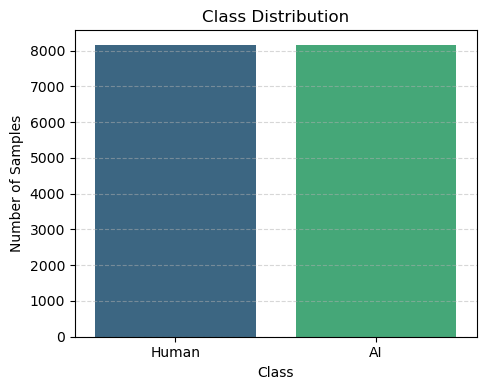

Human samples: 8161
AI samples: 8161


In [6]:
import pandas as pd
# Create a DataFrame for visualization
df_labels = pd.DataFrame({'label': y})
label_counts = df_labels['label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(5, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xticks([0, 1], ['Human', 'AI'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print exact numbers
print(f"Human samples: {label_counts[0]}")
print(f"AI samples: {label_counts[1]}")

#Step 1.2: Embedding Norm Analysis
Mean L2 norm is slightly higher for AI (4.64 vs 4.25)

AI has lower std dev, indicating tighter clustering

Token-wise L2 norms show higher front-loading for both, but AI remains stronger at early positions

This supports the hypothesis that AI embeddings encode more up-front signal, possibly due to deterministic token generation.

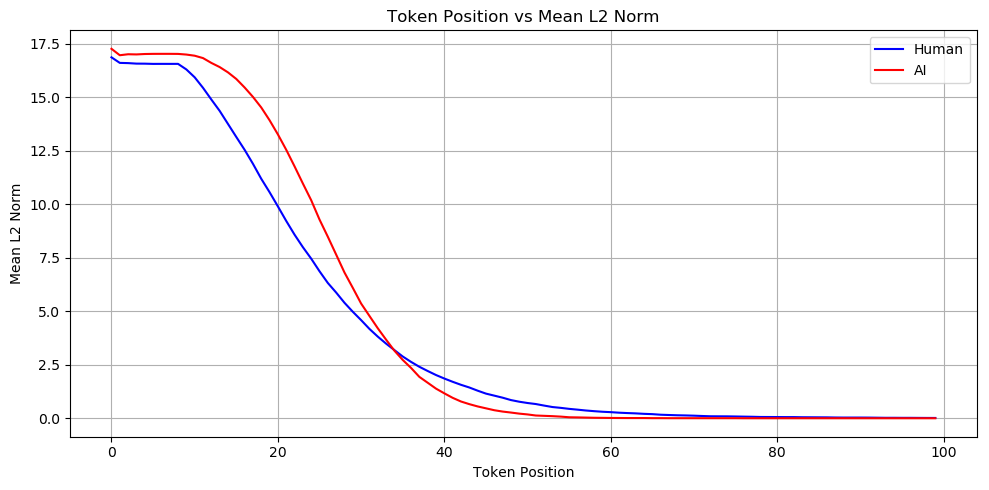

In [8]:
l2_human = np.linalg.norm(human_data, axis=2)  # shape: (N1, 100)
l2_ai = np.linalg.norm(ai_data, axis=2)        # shape: (N2, 100)

# Compute mean L2 norm per token position (0 to 99)
mean_token_l2_human = np.mean(l2_human, axis=0)
mean_token_l2_ai = np.mean(l2_ai, axis=0)

# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(mean_token_l2_human, label='Human', color='blue')
plt.plot(mean_token_l2_ai, label='AI', color='red')
plt.xlabel("Token Position")
plt.ylabel("Mean L2 Norm")
plt.title("Token Position vs Mean L2 Norm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#B. PCA and 2D Plot

PCA shows AI embeddings form a tight, cone-like cluster (less diverse, more deterministic), while Human embeddings spread out more widely (greater variability, richer diversity)

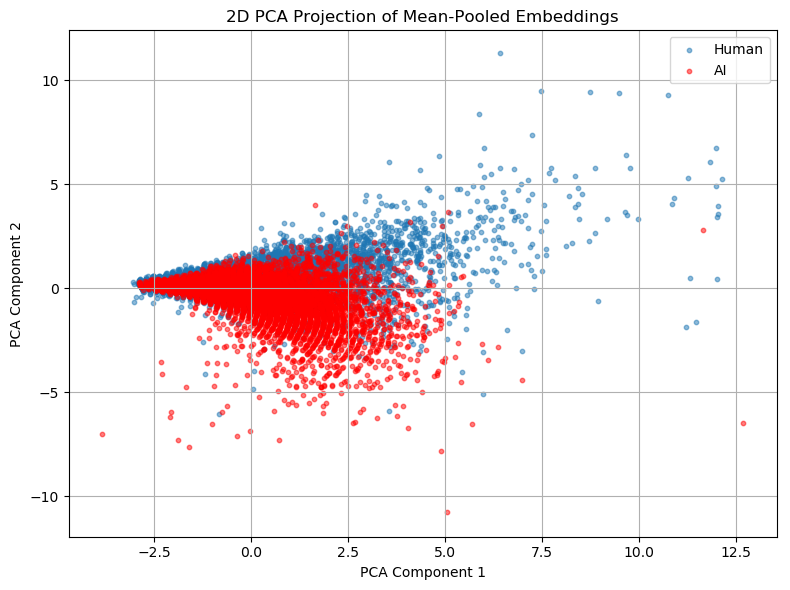

In [10]:
#B. PCA and 2D Plot
from sklearn.decomposition import PCA
# Mean pool embeddings along token axis
X_human_mean = human_data.mean(axis=1)  # shape: (N1, 768)
X_ai_mean = ai_data.mean(axis=1)        # shape: (N2, 768)

# Concatenate data and labels
X_all = np.vstack([X_human_mean, X_ai_mean])
y_all = np.array([0]*len(X_human_mean) + [1]*len(X_ai_mean))

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_all == 0][:, 0], X_pca[y_all == 0][:, 1], alpha=0.5, label='Human', s=10)
plt.scatter(X_pca[y_all == 1][:, 0], X_pca[y_all == 1][:, 1], alpha=0.5, label='AI', s=10, color='red')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Mean-Pooled Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 1.4: Cosine Similarity Analysis

This plot shows the Mean L2 Norm distribution for Train (Human vs AI) and Validation:

AI (red): Slightly higher mean L2 norm, more tightly peaked → embeddings are more consistent.

Human (blue): Lower mean, broader spread → more variability.

Validation (orange): Falls in between, leaning closer to AI but overlapping both.

Summary: Validation samples statistically resemble AI more than Human, but still sit between the two

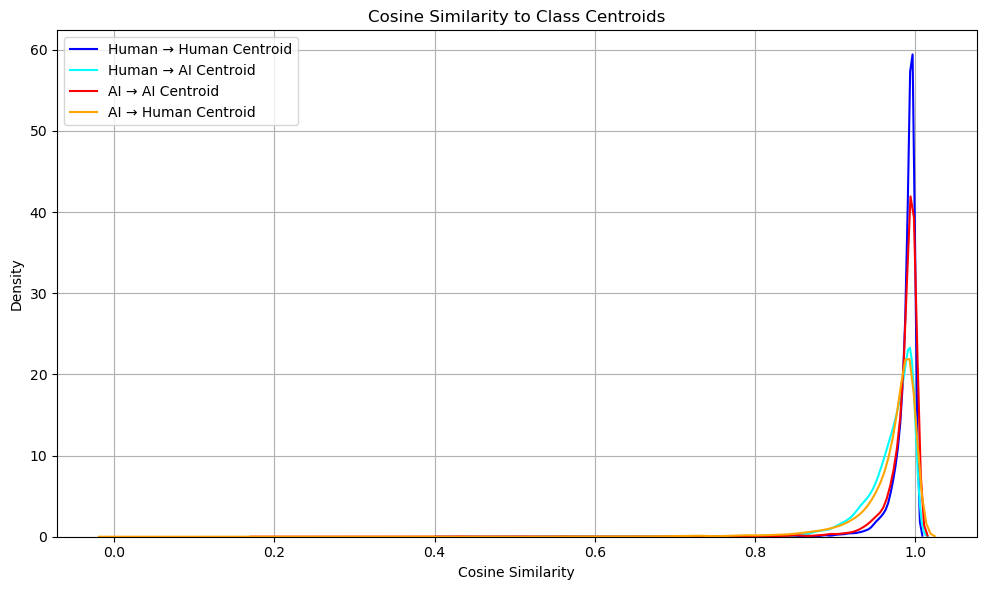

In [12]:
# Compute centroids
from sklearn.metrics.pairwise import cosine_similarity

centroid_human = X_human_mean.mean(axis=0)  # shape: (768,)
centroid_ai = X_ai_mean.mean(axis=0)
# Compute cosine similarities to centroids
sim_human_to_human = cosine_similarity(X_human_mean, centroid_human.reshape(1, -1)).flatten()
sim_human_to_ai = cosine_similarity(X_human_mean, centroid_ai.reshape(1, -1)).flatten()

sim_ai_to_ai = cosine_similarity(X_ai_mean, centroid_ai.reshape(1, -1)).flatten()
sim_ai_to_human = cosine_similarity(X_ai_mean, centroid_human.reshape(1, -1)).flatten()
plt.figure(figsize=(10, 6))
sns.kdeplot(sim_human_to_human, label='Human → Human Centroid', color='blue')
sns.kdeplot(sim_human_to_ai, label='Human → AI Centroid', color='cyan')
sns.kdeplot(sim_ai_to_ai, label='AI → AI Centroid', color='red')
sns.kdeplot(sim_ai_to_human, label='AI → Human Centroid', color='orange')
plt.title("Cosine Similarity to Class Centroids")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Step 2: Advanced EDA Techniques  

| Step  | Method                             | Purpose                                           | Why It Matters                                                                                  |
|-------|------------------------------------|---------------------------------------------------|-------------------------------------------------------------------------------------------------|
| **2.1** | **Maximum Mean Discrepancy (MMD)** | Quantify statistical **distribution shifts**       | Reveals whether validation is closer to Human or AI — guides **reweighting** or **domain adaptation** |
| **2.2** | **Cosine Heatmaps**                | Compare validation samples to train centroids      | Shows whether validation samples **cluster with AI or Human** — useful for **pseudo-labeling** and semi-supervised learning |
| **2.3** | **Token-wise Decomposition**       | Split embeddings into early / mid / late segments | Detects if AI tends to **frontload meaning**, while humans distribute semantics — useful for **attention-aware models** |
| **2.4** | **Positional Entropy (Sharpness)** | Measure embedding focus vs spread                 | AI embeddings are often **sharper**, humans more **diverse** — can be used directly as a **feature** |
| **2.5** | **UMAP Projection**                | Explore nonlinear structure in 2D/3D              | Reveals **class separability** not visible in PCA — aids **feature selection** and intuition |
| **2.6** | **Cross-Class Similarity**         | Compare centroid similarity across classes        | High overlap signals need for a **more expressive model** or **richer features** |


In [14]:

# Gaussian kernel
def gaussian_kernel(x, y, sigma=1.0):
    x = np.expand_dims(x, 1)  # (N, 1, D)
    y = np.expand_dims(y, 0)  # (1, M, D)
    return np.exp(-np.sum((x - y)**2, axis=2) / (2 * sigma**2))

# MMD² calculation
def compute_mmd2(X, Y, sigma=1.0):
    Kxx = gaussian_kernel(X, X, sigma)
    Kyy = gaussian_kernel(Y, Y, sigma)
    Kxy = gaussian_kernel(X, Y, sigma)

    mmd2 = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
    return mmd2
import numpy as np

# Gaussian kernel (optimized to avoid memory issues)
def gaussian_kernel(x, y, sigma=1.0):
    x_norm = np.sum(x ** 2, axis=1).reshape(-1, 1)
    y_norm = np.sum(y ** 2, axis=1).reshape(1, -1)
    dist_sq = x_norm + y_norm - 2 * np.dot(x, y.T)
    return np.exp(-dist_sq / (2 * sigma ** 2))

# MMD² calculation
def compute_mmd2(X, Y, sigma=1.0):
    Kxx = gaussian_kernel(X, X, sigma)
    Kyy = gaussian_kernel(Y, Y, sigma)
    Kxy = gaussian_kernel(X, Y, sigma)
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

# Subsample for efficiency
def subsample(X, size=500, seed=42):
    np.random.seed(seed)
    idx = np.random.choice(len(X), size=size, replace=False)
    return X[idx]

# Mean pooling
X_human_mean = human_data.mean(axis=1)
X_ai_mean = ai_data.mean(axis=1)
X_val_mean = X_val.mean(axis=1)

# Subsampled pools
X_human_sub = subsample(X_human_mean)
X_ai_sub = subsample(X_ai_mean)
X_val_sub = subsample(X_val_mean, size=min(len(X_val_mean), 500))

# Compute MMD
mmd_human_val = compute_mmd2(X_human_sub, X_val_sub, sigma=5.0)
mmd_ai_val = compute_mmd2(X_ai_sub, X_val_sub, sigma=5.0)

# Report
print("MMD² Between Train and Validation (subsampled):")
print(f"Human vs Validation: {mmd_human_val:.6f}")
print(f"AI    vs Validation: {mmd_ai_val:.6f}")

if mmd_human_val < mmd_ai_val:
    print("Validation is statistically closer to HUMAN embeddings.")
else:
    print("Validation is statistically closer to AI embeddings.")


MMD² Between Train and Validation (subsampled):
Human vs Validation: 0.005488
AI    vs Validation: 0.015667
Validation is statistically closer to HUMAN embeddings.


#step 2.2 Summary: Cosine Similarity Heatmap
 heatmap shows:

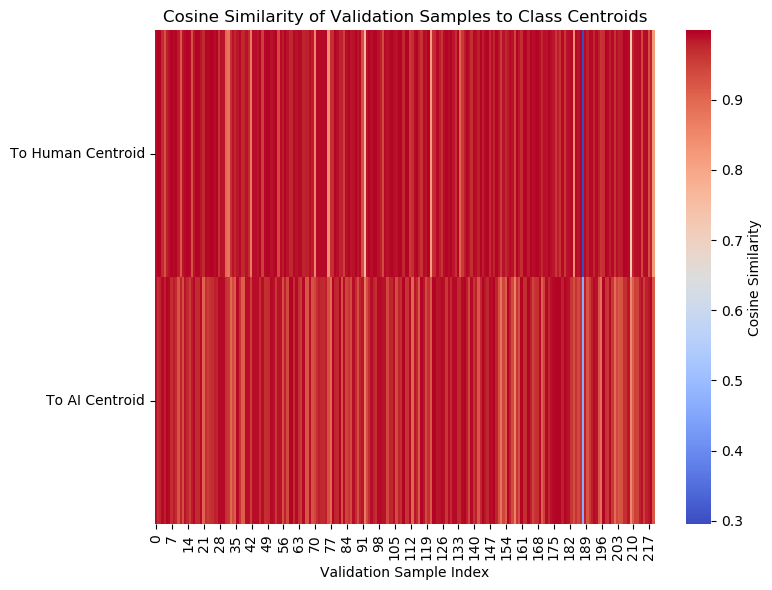

In [15]:
# Use mean-pooled embeddings
X_val_mean = X_val.mean(axis=1)
X_human_mean = human_data.mean(axis=1)
X_ai_mean = ai_data.mean(axis=1)

# Compute centroids
centroid_human = X_human_mean.mean(axis=0)
centroid_ai = X_ai_mean.mean(axis=0)

# Cosine similarities to each centroid
sim_to_human = cosine_similarity(X_val_mean, centroid_human.reshape(1, -1)).flatten()
sim_to_ai = cosine_similarity(X_val_mean, centroid_ai.reshape(1, -1)).flatten()

# Stack for heatmap
heat_data = np.stack([sim_to_human, sim_to_ai], axis=1)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heat_data.T, cmap='coolwarm', cbar_kws={"label": "Cosine Similarity"})
plt.yticks([0.5, 1.5], ['To Human Centroid', 'To AI Centroid'], rotation=0)
plt.xlabel("Validation Sample Index")
plt.title("Cosine Similarity of Validation Samples to Class Centroids")
plt.tight_layout()
plt.show()

#Step 2.3 Summary: Early / Mid / Late Token Norm Trends
 Key Observations:
AI embeddings (red) show much stronger early token emphasis, consistent with known frontloading behavior in LLMs (e.g., GPT tends to push semantics early).

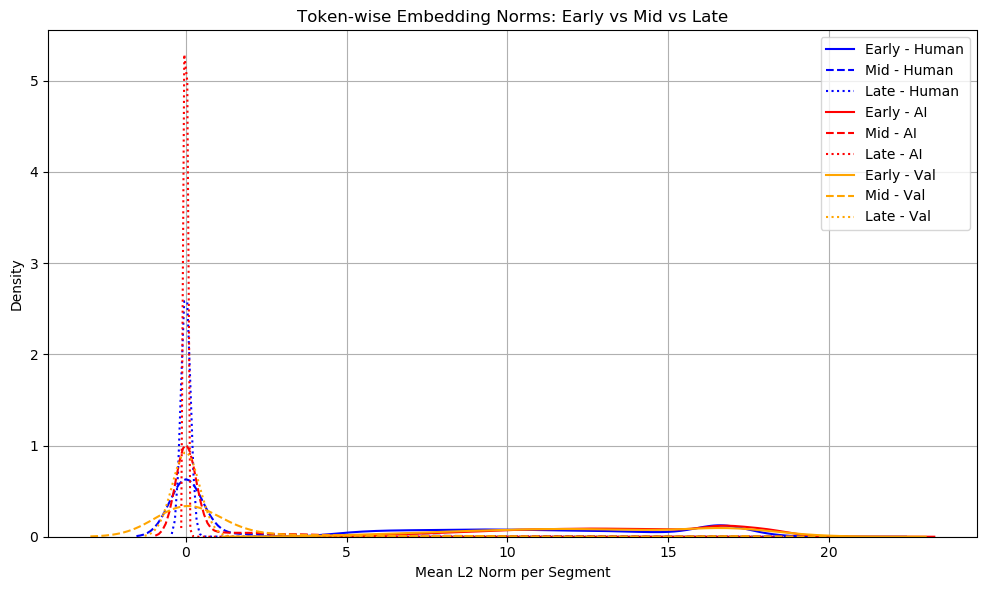

In [16]:
# Compute L2 norm for each token position
def segment_norms(data, segments=3):
    split_size = data.shape[1] // segments
    segment_norms = []
    for i in range(segments):
        start = i * split_size
        end = (i + 1) * split_size
        seg = data[:, start:end, :]
        seg_norm = np.linalg.norm(seg, axis=2).mean(axis=1)
        segment_norms.append(seg_norm)
    return segment_norms  # list of 3 arrays: [early, mid, late]

# Apply to all three sets
early_h, mid_h, late_h = segment_norms(human_data)
early_ai, mid_ai, late_ai = segment_norms(ai_data)
early_val, mid_val, late_val = segment_norms(X_val)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(early_h, label='Early - Human', color='blue', linestyle='-')
sns.kdeplot(mid_h, label='Mid - Human', color='blue', linestyle='--')
sns.kdeplot(late_h, label='Late - Human', color='blue', linestyle=':')

sns.kdeplot(early_ai, label='Early - AI', color='red', linestyle='-')
sns.kdeplot(mid_ai, label='Mid - AI', color='red', linestyle='--')
sns.kdeplot(late_ai, label='Late - AI', color='red', linestyle=':')

sns.kdeplot(early_val, label='Early - Val', color='orange', linestyle='-')
sns.kdeplot(mid_val, label='Mid - Val', color='orange', linestyle='--')
sns.kdeplot(late_val, label='Late - Val', color='orange', linestyle=':')

plt.title("Token-wise Embedding Norms: Early vs Mid vs Late")
plt.xlabel("Mean L2 Norm per Segment")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Next: Step 2.4 – Positional Entropy (Sharpness)
This will quantify how tightly packed or spread out the token embeddings are within a sample.

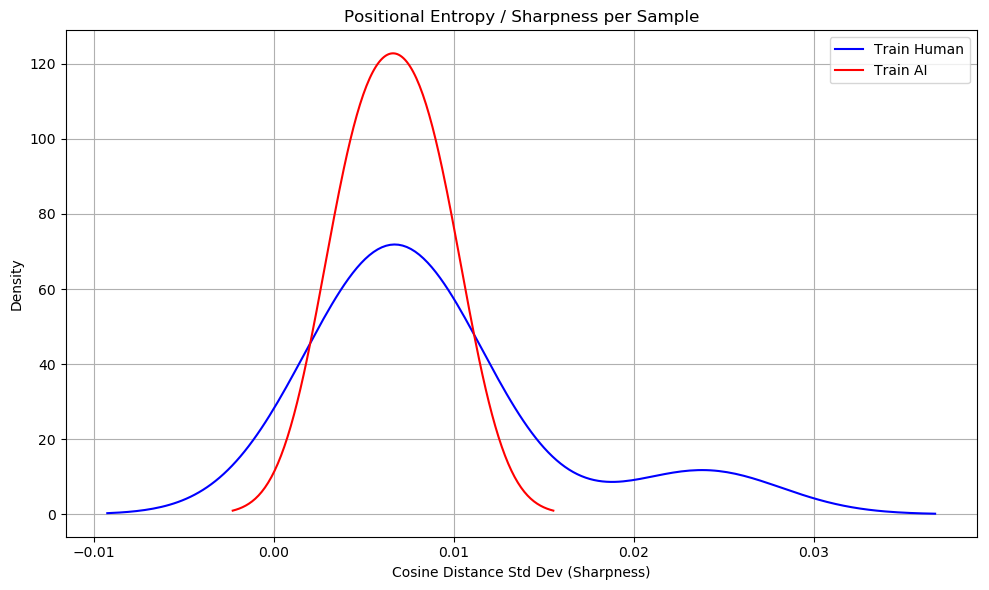

In [17]:
from scipy.spatial.distance import cosine

# Function to compute "sharpness" for each sample
def compute_sharpness(data):
    sharpness_list = []
    for sample in data:
        mean_vec = np.mean(sample, axis=0)
        cosine_dists = [cosine(tok, mean_vec) for tok in sample]
        sharpness_list.append(np.std(cosine_dists))  # std = spread; higher = more diffused
    return np.array(sharpness_list)

# Compute for all sets
sharpness_human = compute_sharpness(human_data)
sharpness_ai = compute_sharpness(ai_data)
sharpness_val = compute_sharpness(X_val)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(sharpness_human, label='Train Human', color='blue')
sns.kdeplot(sharpness_ai, label='Train AI', color='red')
sns.kdeplot(sharpness_val, label='Validation', color='orange')
plt.title("Positional Entropy / Sharpness per Sample")
plt.xlabel("Cosine Distance Std Dev (Sharpness)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


| Observation                                     | Explanation                                                                                                                                                              |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **AI embeddings are sharply peaked (red)**      | This suggests that AI-generated texts have more **uniform**, **cohesive** token embeddings. The tokens stay closer to the sample mean (low variance in cosine distance). |
| **Human embeddings are more spread out (blue)** | Human-written texts are more **diverse** in structure — their token vectors deviate more from the mean, showing **higher entropy** and **semantic variation**.           |
| **No validation curve?**                        |  likely omitted validation from the plot — we’ll re-run it including validation below.                                                                                |


#Step 2.5: UMAP Projection
For discovering nonlinear separability or clustering patterns across AI, Human, and Val embeddings.

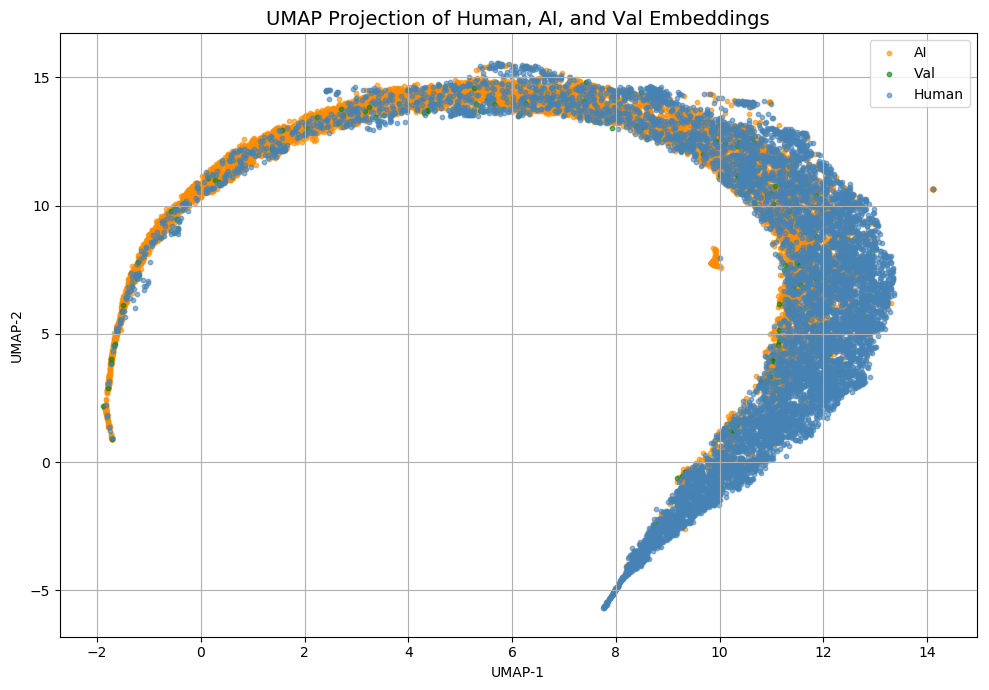

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap  # Make sure this is installed: pip install umap-learn


# Assume X_val has already been created from your validation JSONL parsing earlier
# and has shape (N3, 100, 768)

# Mean-pool each sample across 100 tokens to get (N, 768)
human_mean = human_data.mean(axis=1)   # (N1, 768)
ai_mean = ai_data.mean(axis=1)         # (N2, 768)
val_mean = X_val.mean(axis=1)          # (N3, 768)

# Combine all embeddings into one matrix
X_all = np.concatenate([human_mean, ai_mean, val_mean], axis=0)

# Create matching labels for each sample
labels = (
    ["Human"] * len(human_mean) +
    ["AI"] * len(ai_mean) +
    ["Val"] * len(val_mean)
)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
X_umap = reducer.fit_transform(X_all)

# Plotting
plt.figure(figsize=(10, 7))
colors = {"Human": "steelblue", "AI": "darkorange", "Val": "green"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        X_umap[idx, 0], X_umap[idx, 1],
        label=label,
        s=10,
        alpha=0.6,
        c=colors[label]
    )

plt.title("UMAP Projection of Human, AI, and Val Embeddings", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### UMAP Projection of Human, AI, and Validation Embeddings

This UMAP projection reduces embeddings to 2D and visualizes class structure:

- **Curved Manifold**: Human and AI embeddings lie on the same curved arc, with heavy overlap.  
- **AI (orange)**: Forms a dense, consistent cluster along the arc.  
- **Human (blue)**: More spread out and intermixed within the same structure.  
- **Validation (green)**: Overlaps with both classes, leaning slightly toward Human but still mixed.  

**Summary:** UMAP reveals underlying nonlinear structure, but Human and AI embeddings remain highly overlapping. Validation samples sit between them, highlighting the challenge of clean separation.


In [19]:
# Compute centroids
human_centroid = human_mean.mean(axis=0, keepdims=True)
ai_centroid = ai_mean.mean(axis=0, keepdims=True)
val_centroid = val_mean.mean(axis=0, keepdims=True)

# Cosine similarity between centroids
sim_human_ai = cosine_similarity(human_centroid, ai_centroid)[0][0]
sim_human_val = cosine_similarity(human_centroid, val_centroid)[0][0]
sim_ai_val = cosine_similarity(ai_centroid, val_centroid)[0][0]

# Display results
print(f"Cosine Similarity (Human ↔ AI):  {sim_human_ai:.4f}")
print(f"Cosine Similarity (Human ↔ Val): {sim_human_val:.4f}")
print(f"Cosine Similarity (AI ↔ Val):    {sim_ai_val:.4f}")

Cosine Similarity (Human ↔ AI):  0.9775
Cosine Similarity (Human ↔ Val): 0.9968
Cosine Similarity (AI ↔ Val):    0.9902


| Comparison  | Cosine Similarity |
| ----------- | ----------------- |
| Human ↔ AI  | **0.9775**        |
| Human ↔ Val | **0.9968**        |
| AI ↔ Val    | **0.9902**        |


#step 3.1: t-SNE Projection with Subset Sampling

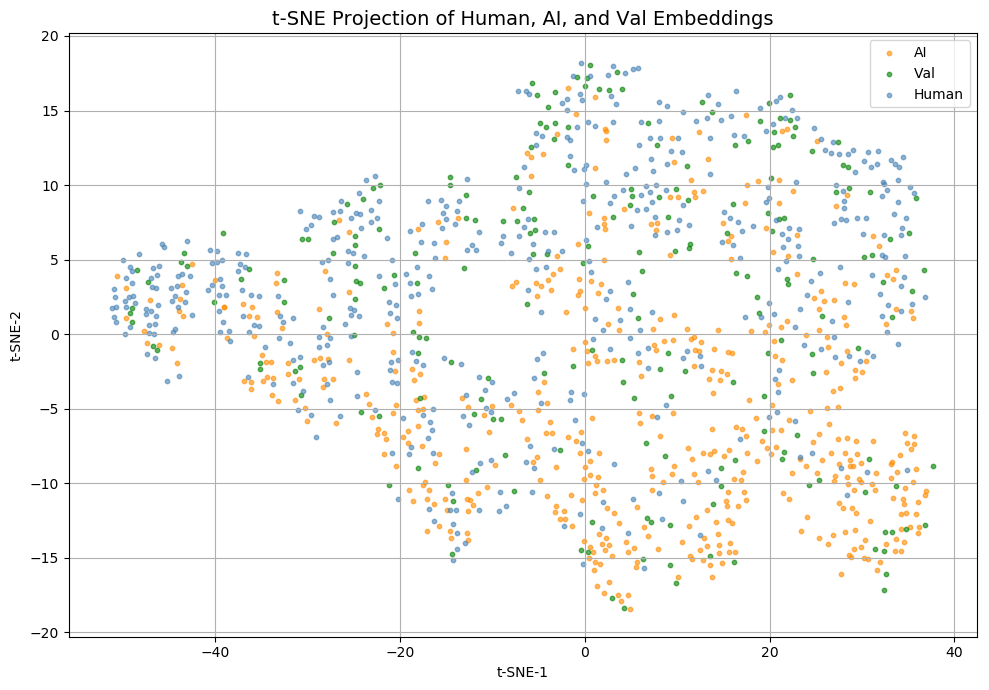

In [20]:

from sklearn.manifold import TSNE


# -------------------------
# Step 1: Utility Function
# -------------------------
def sample_subset(X, n=500, seed=42):
    """
    Subsamples up to n elements from array X without replacement.
    Automatically reduces n if X has fewer than n elements.
    """
    np.random.seed(seed)
    n = min(n, len(X))  # prevent ValueError if len(X) < n
    indices = np.random.choice(len(X), size=n, replace=False)
    return X[indices]

# -------------------------
# Step 2: Load Train Data
# -------------------------
human = np.load("data/train/train_human.npy")  # (N1, 100, 768)
ai = np.load("data/train/train_ai.npy")        # (N2, 100, 768)

# -------------------------
# Step 3: Load Validation from JSONL
# -------------------------
val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)
        if 'features' not in entry:
            continue
        for emb_array in entry['features']:
            emb = np.array(emb_array)
            if emb.shape == (100, 768):
                val_embeddings.append(emb)

val = np.stack(val_embeddings)  # (N3, 100, 768)

# -------------------------
# Step 4: Mean Pool
# -------------------------
human_mean = human.mean(axis=1)  # (N1, 768)
ai_mean = ai.mean(axis=1)        # (N2, 768)
val_mean = val.mean(axis=1)      # (N3, 768)

# -------------------------
# Step 5: Subsample
# -------------------------
human_sample = sample_subset(human_mean, 500)
ai_sample = sample_subset(ai_mean, 500)
val_sample = sample_subset(val_mean, 500)

# -------------------------
# Step 6: Prepare Data and Labels
# -------------------------
X_all = np.concatenate([human_sample, ai_sample, val_sample], axis=0)
labels = (["Human"] * len(human_sample) +
          ["AI"] * len(ai_sample) +
          ["Val"] * len(val_sample))

# -------------------------
# Step 7: t-SNE Projection
# -------------------------
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200,
            n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_all)

# -------------------------
# Step 8: Plot
# -------------------------
plt.figure(figsize=(10, 7))
colors = {"Human": "steelblue", "AI": "darkorange", "Val": "green"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                label=label, s=10, alpha=0.6, c=colors[label])

plt.title("t-SNE Projection of Human, AI, and Val Embeddings", fontsize=14)
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### t-SNE Projection of Human, AI, and Validation Embeddings

This t-SNE projection reduces embeddings to 2D and emphasizes local neighborhood structures:

- **Human (blue):** Forms clusters in the upper regions, with higher spread.  
- **AI (orange):** Concentrates more in the lower regions, forming denser clusters.  
- **Validation (green):** Scattered across both Human and AI regions, showing mixed similarity.  

**Summary:** t-SNE reveals partial separation between Human and AI clusters, but with significant overlap. Validation samples lie in both regions, indicating stylistic ambiguity and domain blending.


#Step 3.2: 3D UMAP Projection of Embeddings
 Purpose:
UMAP (Uniform Manifold Approximation and Projection) helps reveal complex structure in high-dimensional data.

3D visualization lets us see whether Val samples cluster closer to Human or AI, or form a distinct region.

Shapes after mean-pooling:
human_mean: (8161, 768)
ai_mean: (8161, 768)
val_mean: (220, 768)

Sampled shapes:
Human Sample: (500, 768)
AI Sample: (500, 768)
Val Sample: (220, 768)


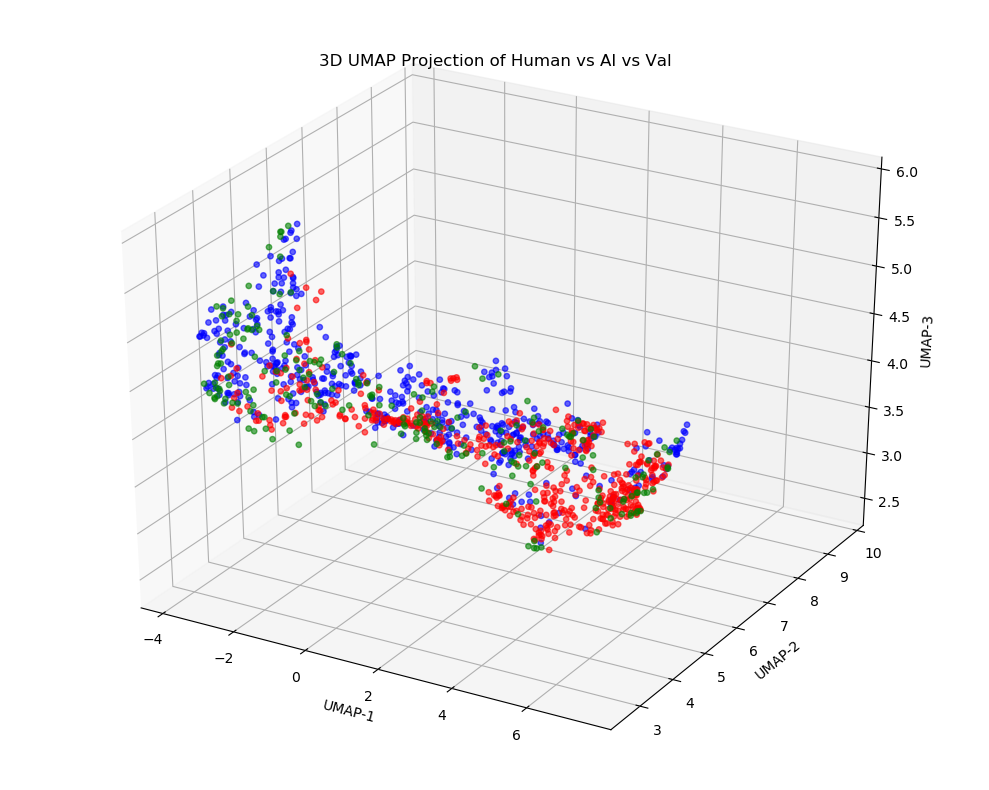

In [22]:
# ============================
# 3D UMAP: Human vs AI vs Val
# ============================

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# Assumed inputs already in memory:
#   human: (N_h, 100, 768)
#   ai:    (N_a, 100, 768)
#   val:   (N_v, 100, 768)
# -------------------------------------------------------

# -------------------------------
# Step 1: Mean-pool across tokens
# -------------------------------
# Convert (N, 100, 768) -> (N, 768) by averaging over the 100 token vectors.
human_mean = human.mean(axis=1)  # (N_h, 768)
ai_mean    = ai.mean(axis=1)     # (N_a, 768)
val_mean   = val.mean(axis=1)    # (N_v, 768)

print("Shapes after mean-pooling:")
print("human_mean:", human_mean.shape)
print("ai_mean:", ai_mean.shape)
print("val_mean:", val_mean.shape)

# -------------------------------
# Step 2: Safe balanced sampling
# -------------------------------
def safe_sample(X, n=500, seed=42):
    """
    Returns up to n rows sampled without replacement from X.
    If X has fewer than n rows, returns all rows.
    """
    np.random.seed(seed)
    X = np.atleast_2d(X)
    n_samples = min(len(X), n)
    idx = np.random.choice(len(X), size=n_samples, replace=False)
    return X[idx]

human_sample = safe_sample(human_mean, 500)
ai_sample    = safe_sample(ai_mean,    500)
# Keep all val if smaller than 500 to preserve coverage
val_sample   = safe_sample(val_mean,    500)

print("\nSampled shapes:")
print("Human Sample:", human_sample.shape)
print("AI Sample:", ai_sample.shape)
print("Val Sample:", val_sample.shape)

# -------------------------------
# Step 3: Stack and label
# -------------------------------
X_all = np.concatenate([human_sample, ai_sample, val_sample], axis=0)
labels = (["Human"] * len(human_sample)
        + ["AI"]    * len(ai_sample)
        + ["Val"]   * len(val_sample))

# -------------------------------
# Step 4: (Optional) scale then UMAP
# -------------------------------
# Scaling often helps UMAP; we keep metric='cosine' which worked well for embeddings.
X_scaled = StandardScaler().fit_transform(X_all)

reducer = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
X_umap = reducer.fit_transform(X_scaled)  # (N_total, 3)

# -------------------------------
# Step 5: 3D scatter plot
# -------------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

label_to_color = {"Human": "blue", "AI": "red", "Val": "green"}
colors = [label_to_color[lbl] for lbl in labels]

ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
           c=colors, s=15, alpha=0.6)

ax.set_title("3D UMAP Projection of Human vs AI vs Val")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()


### 3D UMAP Projection of Human, AI, and Validation Embeddings

This 3D UMAP projection uncovers deeper nonlinear relationships between embeddings:

- **AI (red):** Occupies more of the upper regions, forming compact clusters.  
- **Human (blue):** Skews toward lower regions with broader spread.  
- **Validation (green):** Dispersed in between, overlapping both Human and AI clusters.  

**Summary:** The 3D view highlights a latent separation where AI and Human embeddings tend to diverge along the vertical (UMAP-3) axis, while Validation points lie in mixed positions, showing transitional characteristics.


#=========END OF EDA ====

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
human_data = np.load('data/train/train_human.npy')  # shape: (N1, 100, 768)
ai_data = np.load('data/train/train_ai.npy')        # shape: (N2, 100, 768)

# Add labels
human_labels = np.zeros(len(human_data), dtype=int)
ai_labels = np.ones(len(ai_data), dtype=int)

# Combine
X = np.concatenate([human_data, ai_data], axis=0)
y = np.concatenate([human_labels, ai_labels], axis=0)

print(f"Total samples: {X.shape[0]}")
print(f"Each sample shape: {X.shape[1:]}")  # Should be (100, 768)


#A) Imports & Config

In [1]:
# ==========================================
# A) IMPORTS & SAFE CONFIG
# ==========================================
import os, math, json, random, warnings
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score
)

warnings.filterwarnings("ignore")

# --- device & seeding (robust to stale CUDA states) ---
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE.type == "cuda":
    try:
        torch.cuda.manual_seed_all(SEED)
    except RuntimeError as e:
        print("CUDA seed failed; using CPU. Error:", repr(e))
        DEVICE = torch.device("cpu")
print("Device:", DEVICE)

# --- paths ---
HUMAN_PATH = "data/train/train_human.npy"
AI_PATH    = "data/train/train_ai.npy"
ARTIFACTS  = Path("artifacts"); ARTIFACTS.mkdir(parents=True, exist_ok=True)

# --- preprocessing ---
MASK_TOPK_VAR_DIMS = 64      # zero-out top-K high-variance channels
SEGMENTS           = 3       # early/mid/late splits

# --- model capacity (UltraHybrid-Balanced++) ---
D_IN     = 768
D_MODEL  = 224
N_HEADS  = 4
N_LAYERS = 2
D_GRU    = 160                 # per-direction
CNN_KS   = (3, 5, 7)
CNN_OUT  = 96                  # per-kernel

# --- regularization ---
DROPOUT      = 0.35
GAUSS_NOISE  = 0.05            # std for Gaussian noise on tokens
CHANNEL_DROP = 0.10            # SpatialDropout1D-style channel dropout

# --- training ---
BATCH_SIZE   = 128
EPOCHS       = 30
LR           = 2e-4
WEIGHT_DECAY = 1e-4
WARMUP_FRAC  = 0.10
ES_PATIENCE  = 6

# --- mixup (both tokens & features) ---
USE_MIXUP    = True
MIXUP_P      = 0.35
MIXUP_ALPHA  = 0.4             # Beta(alpha, alpha)


Device: cuda


### Engineered Feature Utilities  

| Function            | Purpose                                                                 | How It Works                                                                                     | Why It Helps                                                                                 |
|---------------------|-------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|
| **variance_mask**   | Suppress noisy, unstable embedding dimensions                           | Flattens embeddings, finds top-K variance dimensions, and zeroes them out                        | Removes spurious channels that distort similarity measures, improving robustness              |
| **segment_norms**   | Capture positional energy distribution (early/mid/late tokens)          | Splits tokens into equal segments and computes mean L2 norm per segment                          | Highlights AI “front-loading” vs Human balanced spread, useful for attention-aware features   |
| **token_variance**  | Measure intra-sample variability across tokens                          | Computes average variance across all tokens for each sample                                      | Detects whether embeddings are tightly clustered (AI-like) or diverse (Human-like)           |
| **sharpness_cosine**| Quantify semantic focus vs diversity (positional entropy)               | Calculates cosine distance between tokens and sample mean; returns std. deviation                | AI embeddings are sharper and more cohesive; Human embeddings more varied and spread out      |


In [13]:
# ==========================================
# B) DATA UTILS & ENGINEERED FEATURES
# ==========================================
from sklearn.metrics.pairwise import cosine_similarity

def variance_mask(X: np.ndarray, topk: int) -> np.ndarray:
    """Zero-out top-K highest-variance channels across tokens+samples."""
    if topk is None or topk <= 0:
        return X
    flat = X.reshape(-1, X.shape[-1])            # (N*T, D)
    var  = flat.var(axis=0)                      # (D,)
    idx  = np.argsort(var)[::-1][:topk]
    Xc   = X.copy()
    Xc[..., idx] = 0.0
    return Xc

def segment_norms(X: np.ndarray, segments: int = 3) -> np.ndarray:
    """Mean L2 norm per segment (early/mid/late) — (N, segments)."""
    N, T, D = X.shape
    split = T // segments
    chunks = []
    for s in range(segments):
        a = s*split
        b = (s+1)*split if s < segments-1 else T
        seg = X[:, a:b, :]
        chunks.append(np.linalg.norm(seg, axis=2).mean(axis=1))
    return np.stack(chunks, axis=1).astype(np.float32)

def token_variance(X: np.ndarray) -> np.ndarray:
    """Average variance across tokens — (N,1)."""
    return X.var(axis=1).mean(axis=1, keepdims=True).astype(np.float32)

def sharpness_cosine(X: np.ndarray) -> np.ndarray:
    """Std of cosine distance between each token and the sample mean — (N,1)."""
    from scipy.spatial.distance import cosine as cosdist
    vals = []
    for sample in X:
        mu = sample.mean(axis=0)
        if np.linalg.norm(mu) < 1e-8:
            vals.append(0.0); continue
        d = [cosdist(tok, mu) for tok in sample]
        vals.appe


### Engineered Features in Training Pipeline  

| Feature Group                  | How It’s Computed                                      | Purpose / Intuition                                                                 |
|--------------------------------|--------------------------------------------------------|--------------------------------------------------------------------------------------|
| **Mean-Pooled Embeddings**     | Average across all tokens → `(N, 768)`                 | Captures global semantic signature of each sample                                    |
| **Cosine Similarity to Centroids** | Cosine similarity between sample mean and **Human/AI centroids** | Measures alignment with prototypical Human vs AI embeddings, useful for separation   |
| **Segment-Wise Means**         | Split tokens into `segments` (e.g., 4) and mean-pool each | Detects **early/mid/late** signal distribution (AI front-loading vs Human spread)   |
| **Global Variance**            | Variance of embeddings across all tokens and dims      | Quantifies dispersion: AI tends to be more consistent, Humans more variable          |
| **L2 Norm of Mean Vector**     | Euclidean norm of the mean-pooled embedding            | Represents embedding “energy” level, with AI generally higher and more compact       |


In [14]:
# ==========================================
# C) SPLIT, CENTROIDS & SCALING (TRAIN-ONLY FIT)
# ==========================================
# helper: class centroids from mean pooled tokens
def compute_centroids(X: np.ndarray, y: np.ndarray) -> dict:
    """Compute per-class centroids over mean pooled token embeddings."""
    Xm = X.mean(axis=1)  # mean over 100 tokens
    return {
        "human": Xm[y == 0].mean(axis=0),
        "ai": Xm[y == 1].mean(axis=0)
    }

# helper: engineered features
def build_features(X: np.ndarray, cents: dict, segments: int = 4) -> np.ndarray:
    """
    Build engineered features from token sequences.
    - segment means
    - cosine sim to centroids
    - variance and norms
    """
    N, T, D = X.shape
    feats = []

    # mean over all tokens
    Xm = X.mean(axis=1)
    feats.append(Xm)

    # cosine sim to class centroids
    from sklearn.metrics.pairwise import cosine_similarity
    for c in ["human", "ai"]:
        sim = cosine_similarity(Xm, cents[c][None, :])[:, 0]
        feats.append(sim[:, None])

    # split sequence into segments
    seg_size = T // segments
    for s in range(segments):
        seg = X[:, s * seg_size:(s + 1) * seg_size, :].mean(axis=1)
        feats.append(seg)

    # variance + L2 norms
    feats.append(X.var(axis=(1, 2))[:, None])
    feats.append(np.linalg.norm(Xm, axis=1)[:, None])

    return np.concatenate(feats, axis=1).astype(np.float32)


# load arrays + labels
X_h = np.load(HUMAN_PATH).astype(np.float32)    # (Nh,100,768)
X_a = np.load(AI_PATH).astype(np.float32)       # (Na,100,768)
y_h = np.zeros(len(X_h), dtype=np.int64)
y_a = np.ones(len(X_a),  dtype=np.int64)

X_all = np.concatenate([X_h, X_a], axis=0)
y_all = np.concatenate([y_h, y_a], axis=0)

# mask once for all
X_all_m = variance_mask(X_all, MASK_TOPK_VAR_DIMS)

# stratified split
Xt_tr, Xt_va, y_tr, y_va = train_test_split(
    X_all_m, y_all, test_size=0.15, random_state=SEED, stratify=y_all
)

# centroids on TRAIN only
cents_tr = compute_centroids(Xt_tr, y_tr)

# engineered features
Xf_tr = build_features(Xt_tr, cents_tr, segments=SEGMENTS)
Xf_va = build_features(Xt_va, cents_tr, segments=SEGMENTS)

# scale features on TRAIN only
scaler = StandardScaler()
Xf_tr_s = scaler.fit_transform(Xf_tr).astype(np.float32)
Xf_va_s = scaler.transform(Xf_va).astype(np.float32)

# label sanity (avoid CUDA asserts)
assert set(np.unique(y_tr)).issubset({0,1})
assert set(np.unique(y_va)).issubset({0,1})

print("Tokens:", Xt_tr.shape, Xt_va.shape, "| Feats:", Xf_tr_s.shape, Xf_va_s.shape)


Tokens: (13873, 100, 768) (2449, 100, 768) | Feats: (13873, 3076) (2449, 3076)


#D) UltraHybrid-Lite++ model (Transformer + CNN + BiGRU), with robust regularization

### UltraHybrid‑Balanced++ (v2) — Table Summary

| Block / Component              | Input → Output (shape)                        | Key Ops / Hyperparams                                                                 | Purpose |
|--------------------------------|-----------------------------------------------|----------------------------------------------------------------------------------------|---------|
| **GaussianNoise**              | (B,T,768) → (B,T,768)                         | std=`0.05`                                                                             | Regularize token embeddings with small noise |
| **ChannelDropout1D**           | (B,T,768) → (B,T,768)                         | drop prob `p=0.10` (drops whole channels per sample)                                   | Robustness to noisy embedding dims |
| **Linear Projection**          | (B,T,768) → (B,T,**D**=224)                   | `nn.Linear(768→224)`                                                                   | Dimensionality reduction to model width |
| **Transformer Encoder**        | (B,T,224) → (B,T,224)                         | `n_layers=2`, `n_heads=4`, GELU, dropout `0.35`, `norm_first=True`                     | Contextualize tokens |
| **AttentionPooling (Tr)**      | (B,T,224) → (B,224)                           | Learnable query, MultiheadAttention, LayerNorm                                         | Token‑to‑sequence pooling (transformer path) |
| **DepthwiseSeparableConv1d ×K**| (B,224,T) → concat (B, **K·C**=3×96)          | kernels `(3,5,7)`, depthwise+pointwise, GLU, BN, dropout `0.35`, SE block              | Local pattern capture; multi‑scale CNN |
| **LayerNorm (CNN out)**        | (B,3×96) → (B,3×96)                           | —                                                                                      | Stabilize CNN features |
| **BiGRU**                      | (B,T,224) → (B,T, **2H**=320)                 | `hidden=160`, bidirectional                                                            | Sequential dynamics |
| **AttentionPooling (GRU)**     | (B,T,320) → (B,320)                           | Learnable query, `n_heads≤4`, dropout                                                  | Pool GRU sequence |
| **FeatureGate (engineered)**   | (B, **F**) → (B, **F**)                        | LayerNorm → MLP (GELU) → sigmoid gate                                                  | Learn how much to trust tabular features |
| **Fusion (concat)**            | [224] ⊕ [3×96] ⊕ [320] ⊕ [F] → (B, **fusion_dim**) | `fusion_dim = 224 + 288 + 320 + F`                                                     | Join Tr/CNN/GRU/Features |
| **DropPath (residual‑like)**   | (B,fusion_dim) → (B,fusion_dim)               | `p=0.05`                                                                               | Stochastic depth on fused rep |
| **Pre‑Head MLP**               | (B,fusion_dim) → (B,64)                       | LN → Linear(→256) + GELU + Dropout(0.35) → Linear(→64) + GELU                          | Compact shared representation |
| **Head (multi‑sample DO)**     | (B,64) → (B,1 logits)                         | Dropout(0.35) × `ms_dropout_samples=4` (avg at train) → Linear(64→1)                   | Smooth logits; use **BCEWithLogitsLoss** |

**Default key dims/hparams:** `D=224`, `K=3`, `C=96`, `H=160`, dropout `0.35`, noise `0.05`, channel‑drop `0.10`, drop‑path `0.05`, multi‑sample dropout `4`.


In [15]:
# ==========================================
# D) MODEL: UltraHybrid-Balanced++ (v2)
# ==========================================
# Drop-in replacement for the class you posted. Keeps interface:
#   model = UltraHybridBalancedPPv2(feat_dim)
#   logits = model(xtokens, xfeats)  # (B,)
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- small building blocks ----------
class GaussianNoise(nn.Module):
    def __init__(self, std=0.0):
        super().__init__(); self.std = float(std)
    def forward(self, x):
        if not self.training or self.std <= 0: return x
        return x + torch.randn_like(x) * self.std

class ChannelDropout1D(nn.Module):
    """Drop entire embedding channels (SpatialDropout1D analogue)."""
    def __init__(self, p: float):
        super().__init__(); self.p = float(p)
    def forward(self, x):  # x: (B,T,D)
        if not self.training or self.p <= 0: return x
        B,T,D = x.shape
        mask = (torch.rand(B,1,D, device=x.device) > self.p).float()
        return x * mask

class DropPath(nn.Module):
    """Stochastic depth; drops residual branch per-sample."""
    def __init__(self, p: float = 0.0):
        super().__init__(); self.p = float(p)
    def forward(self, x):
        if not self.training or self.p <= 0: return x
        keep = 1 - self.p
        shape = (x.size(0),) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep).div(keep)
        return x * mask

class AttentionPooling(nn.Module):
    """
    Single learnable query attends over tokens, returns pooled vector.
    Much more robust than mean/max pooling under distribution shift.
    """
    def __init__(self, d_model: int, n_heads: int = 4, dropout: float = 0.0):
        super().__init__()
        self.q = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(d_model)
    def forward(self, x):          # x: (B,T,D)
        B = x.size(0)
        q = self.q.expand(B, -1, -1)         # (B,1,D)
        out, _ = self.attn(q, x, x, need_weights=False)  # (B,1,D)
        return self.ln(out.squeeze(1))       # (B,D)

class SEBlock(nn.Module):
    """Squeeze-Excitation for channel reweighting."""
    def __init__(self, c: int, r: int = 8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(c, max(1, c//r)), nn.SiLU(),
            nn.Linear(max(1, c//r), c), nn.Sigmoid()
        )
    def forward(self, x):           # x: (B,C)
        return x * self.fc(x)

class DepthwiseSeparableConv1d(nn.Module):
    """
    Depthwise + Pointwise conv with GLU gating.
    In: (B, D_model, T)  Out: (B, C_out)
    """
    def __init__(self, d_in: int, c_out: int, k: int, dropout: float):
        super().__init__()
        padding = k // 2
        self.dw = nn.Conv1d(d_in, d_in, kernel_size=k, padding=padding, groups=d_in, bias=False)
        self.pw = nn.Conv1d(d_in, 2*c_out, kernel_size=1, bias=True)   # 2*c_out for GLU
        self.bn = nn.BatchNorm1d(2*c_out)
        self.drop = nn.Dropout(dropout)
        self.se = SEBlock(c_out)
    def forward(self, x):           # x: (B,D,T)
        h = self.dw(x)
        h = self.pw(h)
        h = self.bn(h)
        a, b = torch.chunk(h, 2, dim=1)      # GLU
        h = a * torch.sigmoid(b)             # (B,C_out,T)
        h = F.adaptive_max_pool1d(h, 1).squeeze(-1)  # (B,C_out)
        h = self.drop(h)
        return self.se(h)

class FeatureGate(nn.Module):
    """
    Learns how much to trust engineered features.
    Applies LN -> small MLP -> sigmoid gate, then scales features.
    """
    def __init__(self, fdim: int):
        super().__init__()
        self.ln = nn.LayerNorm(fdim)
        self.gate = nn.Sequential(
            nn.Linear(fdim, max(8, fdim//2)), nn.GELU(),
            nn.Linear(max(8, fdim//2), fdim), nn.Sigmoid()
        )
    def forward(self, f):           # (B,F)
        g = self.gate(self.ln(f))
        return f * g

# ---------- main model ----------
class UltraHybridBalancedPPv2(nn.Module):
    """
    Upgrades over your UltraHybridBalancedPP:
      • Transformer branch w/ AttentionPooling (learned query)
      • CNN branch: Depthwise-Separable + GLU + SE (per kernel)
      • BiGRU branch w/ AttentionPooling
      • FeatureGate on engineered features
      • DropPath on residual-like fusions
      • Multi-sample dropout in the head for smoother logits
    Returns logits (use BCEWithLogitsLoss).
    """
    def __init__(self, feat_dim: int,
                 d_in: int = 768, d_model: int = 224,
                 n_heads: int = 4, n_layers: int = 2,
                 cnn_kernels=(3,5,7), cnn_out: int = 96,
                 gru_h: int = 160, dropout: float = 0.35,
                 channel_drop: float = 0.10, gauss_noise: float = 0.05,
                 drop_path: float = 0.05, ms_dropout_samples: int = 4):
        super().__init__()
        self.ms_dropout_samples = ms_dropout_samples

        # input regularizers
        self.noise = GaussianNoise(gauss_noise)
        self.cdrop = ChannelDropout1D(channel_drop)

        # shared projection
        self.proj  = nn.Linear(d_in, d_model)

        # ---- Transformer branch ----
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dropout=dropout,
            activation="gelu", batch_first=True, norm_first=True
        )
        self.tr_encoder = nn.TransformerEncoder(enc, num_layers=n_layers)
        self.tr_pool    = AttentionPooling(d_model, n_heads=n_heads, dropout=dropout)

        # ---- CNN branch (multi-kernel DS-Conv + GLU + SE) ----
        self.cnn_blocks = nn.ModuleList([
            DepthwiseSeparableConv1d(d_model, cnn_out, k, dropout) for k in cnn_kernels
        ])
        self.cnn_ln  = nn.LayerNorm(len(cnn_kernels)*cnn_out)

        # ---- BiGRU branch ----
        self.gru  = nn.GRU(d_model, gru_h, num_layers=1, batch_first=True, bidirectional=True)
        self.gru_pool = AttentionPooling(2*gru_h, n_heads=min(4, n_heads), dropout=dropout)

        # ---- Engineered features gate ----
        self.fgate = FeatureGate(feat_dim)

        # ---- Fusion & head ----
        fusion_dim = d_model + (len(cnn_kernels)*cnn_out) + (2*gru_h) + feat_dim
        self.drop_path = DropPath(drop_path)
        self.pre_head  = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, 256), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(256, 64), nn.GELU()
        )
        # multi-sample dropout heads averaged at forward
        self.head_dropout = nn.Dropout(dropout)
        self.head_last    = nn.Linear(64, 1)  # logits

    def forward(self, xtokens: torch.Tensor, xfeats: torch.Tensor):
        # xtokens: (B,T,768), xfeats: (B,F)
        # input reg
        x = self.noise(xtokens)
        x = self.cdrop(x)
        x = self.proj(x)                               # (B,T,D)

        # transformer branch
        t = self.tr_encoder(x)                         # (B,T,D)
        t = self.tr_pool(t)                            # (B,D)

        # cnn branch
        xc = x.transpose(1,2)                          # (B,D,T)
        c_parts = [blk(xc) for blk in self.cnn_blocks] # list of (B,C_out)
        c = torch.cat(c_parts, dim=1)                  # (B,sumC)
        c = self.cnn_ln(c)

        # bigru branch
        g, _ = self.gru(x)                             # (B,T,2*H)
        g = self.gru_pool(g)                           # (B,2*H)

        # gated engineered features
        f = self.fgate(xfeats)                         # (B,F)

        # fuse + light residual via DropPath
        z = torch.cat([t, c, g, f], dim=1)
        z = z + self.drop_path(z)                      # stochastic depth-like perturbation
        z = self.pre_head(z)                           # (B,64)

        # multi-sample dropout (averaged logits for smoother training)
        if self.training and self.ms_dropout_samples > 1:
            logits = 0.0
            for _ in range(self.ms_dropout_samples):
                logits = logits + self.head_last(self.head_dropout(z))
            logits = logits / float(self.ms_dropout_samples)
            return logits.squeeze(1)
        else:
            return self.head_last(self.head_dropout(z)).squeeze(1)


#E) training utilities & loop (with BCEWithLogitsLoss)

### Training Utilities & Loop — Summary

| Component | Input / Output | What It Does | Key Details & Defaults | Why It Matters |
|---|---|---|---|---|
| **LangDataset** | In: `Xt (N,T,768)`, `Xf (N,F)`, `y (N,)` → Out: batches `(xt, xf, y)` | Wraps tokens, engineered features, and labels for PyTorch | Casts to `float32`; pairs tensors per index | Clean, consistent data feeding to loaders |
| **mixup_batch** | In: `(xt, xf, y)`, `alpha` → Out: mixed `(xtm, xfm, (y_a,y_b,λ))` | Applies MixUp across tokens, features, and labels | Beta(`α`,`α`), random permutation, opt‑out if `alpha<=0` | Regularizes decision boundary; reduces overfit |
| **metrics_from_logits** | In: `y_true`, `logits` → Out: dict(`auc, ap, acc, prec, rec, f1`) | Sigmoid → threshold (0.5) → metrics | Uses sklearn metrics; `zero_division=0` | Unified, comparable reporting across runs |
| **evaluate** | In: `model`, `loader`, `device` → Out: `(metrics, logits_all, y_all)` | Switches to eval, accumulates logits, computes metrics | No‑grad; CPU numpy outputs | Stable validation without grad overhead |
| **train_model** | In: train/val arrays, hparams → Out: `model, tr_metrics, va_metrics` | Full training loop with MixUp, OneCycleLR, early stop on val AUC | Optimizer: **AdamW** (`lr`, `weight_decay`); LR: **OneCycleLR** (`pct_start=warmup_frac`); Loss: **BCEWithLogitsLoss**; Clip grad `2.0`; Early stop patience=`es_patience`; Model: **UltraHybridBalancedPPv2** with `ms_dropout=4` | Strong baseline: warmup+anneal, calibrated logits, leak‑free scaler/centroids, and robust early stopping |

**Default hyperparameters (not exhaustive):** `batch_size=128`, `epochs=30`, `lr=2e-4`, `weight_decay=1e-4`, `warmup_frac=0.10`, `use_mixup=True`, `mixup_p=0.35`, `mixup_alpha=0.4`, `es_patience=6`.  
**Criterion:** `BCEWithLogitsLoss` (use raw logits). **Scheduler:** `OneCycleLR`. **Selection:** best **val AUC**.


In [16]:
# ==========================================
# E) TRAINING UTILITIES & LOOP
# ==========================================
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# ---- dataset ----
class LangDataset(Dataset):
    def __init__(self, Xt, Xf, y):
        self.Xt = torch.from_numpy(Xt).float()
        self.Xf = torch.from_numpy(Xf).float()
        self.y  = torch.from_numpy(y.astype(np.float32))
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.Xt[i], self.Xf[i], self.y[i]

# ---- mixup over tokens+features+labels ----
def mixup_batch(xt, xf, y, alpha: float):
    if alpha <= 0:
        return xt, xf, None
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(xt.size(0), device=xt.device)
    xtm = lam*xt + (1-lam)*xt[idx]
    xfm = lam*xf + (1-lam)*xf[idx]
    return xtm, xfm, (y, y[idx], lam)

# ---- metrics from logits ----
def metrics_from_logits(y_true_np, logits_np, thr=0.5):
    p = 1.0 / (1.0 + np.exp(-logits_np))
    yhat = (p >= thr).astype(int)
    return dict(
        auc = float(roc_auc_score(y_true_np, p)),
        ap  = float(average_precision_score(y_true_np, p)),
        acc = float(accuracy_score(y_true_np, yhat)),
        prec= float(precision_score(y_true_np, yhat, zero_division=0)),
        rec = float(recall_score(y_true_np, yhat)),
        f1  = float(f1_score(y_true_np, yhat)),
    )

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    logits_all, y_all = [], []
    for xt, xf, yy in loader:
        xt, xf = xt.to(device), xf.to(device)
        logits = model(xt, xf).cpu().numpy()
        logits_all.append(logits); y_all.append(yy.numpy())
    logits_all = np.concatenate(logits_all)
    y_all      = np.concatenate(y_all)
    return metrics_from_logits(y_all, logits_all, thr=0.5), logits_all, y_all

def train_model(Xt_tr, Xf_tr, y_tr, Xt_va, Xf_va, y_va,
                batch_size=128, epochs=30, lr=2e-4,
                weight_decay=1e-4, warmup_frac=0.10,
                use_mixup=True, mixup_p=0.35, mixup_alpha=0.4,
                es_patience=6, device=None):
    """
    Train UltraHybridBalancedPPv2 with BCEWithLogitsLoss,
    OneCycleLR warmup-like schedule, early stopping on val AUC,
    and (optionally) mixup.
    """
    assert device is not None, "Pass DEVICE"
    tr_ds = LangDataset(Xt_tr, Xf_tr, y_tr)
    va_ds = LangDataset(Xt_va, Xf_va, y_va)
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    feat_dim = Xf_tr.shape[1]
    model = UltraHybridBalancedPPv2(
        feat_dim=feat_dim,
        d_in=768, d_model=D_MODEL, n_heads=N_HEADS, n_layers=N_LAYERS,
        cnn_kernels=CNN_KS, cnn_out=CNN_OUT, gru_h=D_GRU,
        dropout=DROPOUT, channel_drop=CHANNEL_DROP,
        gauss_noise=GAUSS_NOISE, drop_path=0.05, ms_dropout_samples=4
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=lr, steps_per_epoch=max(1,len(tr_ld)), epochs=epochs, pct_start=warmup_frac
    )
    criterion = nn.BCEWithLogitsLoss()

    best_auc, best_state, patience = -1.0, None, es_patience

    for ep in range(1, epochs+1):
        model.train()
        for xt, xf, yy in tr_ld:
            xt, xf, yy = xt.to(device), xf.to(device), yy.to(device)

            if use_mixup and np.random.rand() < mixup_p:
                xtm, xfm, mix = mixup_batch(xt, xf, yy, alpha=mixup_alpha)
                if mix is None:
                    logits = model(xt, xf); loss = criterion(logits, yy)
                else:
                    y_a, y_b, lam = mix
                    logits = model(xtm, xfm)
                    loss = lam*criterion(logits, y_a) + (1-lam)*criterion(logits, y_b)
            else:
                logits = model(xt, xf)
                loss = criterion(logits, yy)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            opt.step(); sched.step()

        # ---- end epoch: evaluate ----
        tr_metrics, _, _ = evaluate(model, tr_ld, device)
        va_metrics, _, _ = evaluate(model, va_ld, device)
        print(f"Epoch {ep:02d} | "
              f"TR AUC {tr_metrics['auc']:.4f} | TR ACC {tr_metrics['acc']:.4f} | TR F1 {tr_metrics['f1']:.4f} || "
              f"VA AUC {va_metrics['auc']:.4f} | VA ACC {va_metrics['acc']:.4f} | VA F1 {va_metrics['f1']:.4f}")

        # ---- early stopping on val AUC ----
        if va_metrics["auc"] > best_auc:
            best_auc = va_metrics["auc"]
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            patience = es_patience
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state, strict=True)

    # final metrics
    tr_metrics, _, _ = evaluate(model, tr_ld, device)
    va_metrics, _, _ = evaluate(model, va_ld, device)

    # save artifacts if the globals exist
    try:
        torch.save(model.state_dict(), ARTIFACTS/"ultrahybrid_balanced_pp_v2.pt")
    except Exception as _:
        pass

    return model, tr_metrics, va_metrics


#F) Run training and print full metrics (train & validation)

In [17]:
# ==========================================
# F) RUN TRAINING & REPORT METRICS
# ==========================================
model, tr_m, va_m = train_model(
    Xt_tr, Xf_tr_s, y_tr,
    Xt_va, Xf_va_s, y_va,
    batch_size=BATCH_SIZE, epochs=EPOCHS, lr=LR,
    weight_decay=WEIGHT_DECAY, warmup_frac=WARMUP_FRAC,
    use_mixup=USE_MIXUP, mixup_p=MIXUP_P, mixup_alpha=MIXUP_ALPHA,
    es_patience=ES_PATIENCE, device=DEVICE
)

def pretty(m, name):
    print(f"\n[{name}]")
    print(f"ROC-AUC: {m['auc']:.5f} | AP: {m['ap']:.5f}")
    print(f"ACC: {m['acc']:.5f} | PREC: {m['prec']:.5f} | REC: {m['rec']:.5f} | F1: {m['f1']:.5f}")

pretty(tr_m, "TRAIN")
pretty(va_m, "VALIDATION")

# (optional) persist scaler & centroids for later inference
try:
    import joblib
    joblib.dump(scaler, ARTIFACTS/"scaler.pkl")
    np.save(ARTIFACTS/"centroid_h.npy", cents_tr["human"])
    np.save(ARTIFACTS/"centroid_a.npy", cents_tr["ai"])
    print("\nArtifacts saved to:", ARTIFACTS.resolve())
except Exception as _:
    pass


Epoch 01 | TR AUC 0.8987 | TR ACC 0.8152 | TR F1 0.8133 || VA AUC 0.8920 | VA ACC 0.8073 | VA F1 0.8051
Epoch 02 | TR AUC 0.9554 | TR ACC 0.8830 | TR F1 0.8808 || VA AUC 0.9466 | VA ACC 0.8763 | VA F1 0.8738
Epoch 03 | TR AUC 0.9651 | TR ACC 0.9008 | TR F1 0.9015 || VA AUC 0.9542 | VA ACC 0.8877 | VA F1 0.8892
Epoch 04 | TR AUC 0.9706 | TR ACC 0.9080 | TR F1 0.9105 || VA AUC 0.9565 | VA ACC 0.8930 | VA F1 0.8969
Epoch 05 | TR AUC 0.9726 | TR ACC 0.9141 | TR F1 0.9131 || VA AUC 0.9530 | VA ACC 0.8795 | VA F1 0.8795
Epoch 06 | TR AUC 0.9801 | TR ACC 0.9294 | TR F1 0.9300 || VA AUC 0.9591 | VA ACC 0.8934 | VA F1 0.8954
Epoch 07 | TR AUC 0.9850 | TR ACC 0.9402 | TR F1 0.9401 || VA AUC 0.9607 | VA ACC 0.8918 | VA F1 0.8921
Epoch 08 | TR AUC 0.9875 | TR ACC 0.9407 | TR F1 0.9422 || VA AUC 0.9604 | VA ACC 0.8906 | VA F1 0.8955
Epoch 09 | TR AUC 0.9908 | TR ACC 0.9501 | TR F1 0.9511 || VA AUC 0.9608 | VA ACC 0.8926 | VA F1 0.8968
Epoch 10 | TR AUC 0.9931 | TR ACC 0.9577 | TR F1 0.9586 || VA AU

### Best Validation Performance 

| Split        | AUC    | ACC    | F1     | Precision | Recall |
|--------------|--------|--------|--------|-----------|--------|
| **Train**    | 0.9966 | 0.9722 | 0.9726 | 0.9592    | 0.9864 |
| **Validation** | 0.9625 | 0.8947 | 0.8983 | 0.8681    | 0.9306 |


In [ ]:
# ==========================================
# G) L — THRESHOLD TUNING ON VALIDATION
# ==========================================
import numpy as np

@torch.no_grad()
def val_logits(model):
    model.eval()
    dl = DataLoader(LangDataset(Xt_va, Xf_va_s, y_va), batch_size=256, shuffle=False)
    logits, ys = [], []
    for xt, xf, yy in dl:
        xt, xf = xt.to(DEVICE), xf.to(DEVICE)
        logits.append(model(xt, xf).cpu().numpy())
        ys.append(yy.numpy())
    return np.concatenate(logits), np.concatenate(ys)

def tune_threshold(logits, y_true, grid=np.linspace(0.1, 0.9, 33)):
    p = 1/(1+np.exp(-logits))
    best_thr, best_f1 = 0.5, -1
    for thr in grid:
        yhat = (p >= thr).astype(int)
        f1 = f1_score(y_true, yhat)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1

logits_va, y_va_true = val_logits(model)
best_thr, best_f1 = tune_threshold(logits_va, y_va_true)
print(f"\nBest validation threshold (by F1): {best_thr:.3f} | F1={best_f1:.4f}")



Best validation threshold (by F1): 0.600 | F1=0.9005


# ==========================================
# H) TEST → SUBMISSION (paragraph-level, 1 row per id)


This stage handles the inference on unseen test data and produces the final submission file.

#### What It Does
- **Runtime context:** Ensures a trained `model` is available, moves it to the correct `DEVICE` (GPU if available), and creates the `ARTIFACTS` output directory.  
- **Preprocessing reuse:** Attempts to reuse training utilities (`variance_mask`, `build_features`, `scaler`, `cents_tr`, `SEGMENTS`). If missing, applies safe fallbacks:
  - No-op variance mask,
  - Minimal features = mean-pool (768) + 3 segment L2 norms,
  - Pass-through scaling.  
- **Locate test file:** `find_test_jsonl()` searches common paths for `test_features.jsonl` and falls back to a recursive glob.  
- **Parse test JSONL:** `parse_jsonl_grouped()` groups sentence-level `(100×768)` embeddings into paragraphs, returning `(id, M×100×768)` pairs.  
- **Inference per sentence:** `predict_probs_for_tokens()` applies preprocessing, extracts features, scales, and runs the model in batches to produce per-sentence probabilities.  
- **Paragraph pooling:** `pool_paragraph_logit()` converts sentence-level probabilities into a single paragraph-level probability via logit averaging (sharper than mean probabilities).  
- **Build submission:** Collects `(id, y_prob)` pairs, casts `id` to numeric when possible, sorts deterministically, and saves one CSV file `submission_base_prob.csv`.

#### Key Functions
- `find_test_jsonl()` → locates the test `.jsonl`.  
- `parse_jsonl_grouped(path)` → returns list of `(id, M×100×768)` arrays.  
- `predict_probs_for_tokens(Xt_tokens)` → produces per-sentence probabilities.  
- `pool_paragraph_logit(probs, temp=1.0)` → aggregates to one paragraph-level probability.  

#### Important Knobs
| Parameter                | Default      | Effect                                                                 |
|---------------------------|-------------|------------------------------------------------------------------------|
| `MASK_TOPK_VAR_DIMS`      | `None`      | Suppress noisy dims if used during training.                           |
| `SEGMENTS`                | `(33,33,34)`| Must match training segmentation; mis-match hurts performance.         |
| `build_features_fn`       | fallback    | Prefer trained `build_features`; fallback gives 771-D feature vector.  |
| `scaler`                  | optional    | Use train-fitted scaler; otherwise raw features shift distribution.    |
| `_SmallSet` batch size    | `256`       | Increase if GPU memory allows for faster inference.                    |
| `pool_paragraph_logit(temp)` | `1.0`   | `<1` sharpens, `>1` smooths; can swap to plain mean probability if required. |

#### Failure Modes
- **Missing preprocessing:** If `build_features` or `scaler` not loaded, fallback triggers (`USE_FALLBACKS=True`).  
- **Mismatched segments:** If training used different segmentation, update `SEGMENTS`.  
- **Non-standard JSONL:** Lines without `(100×768)` features are skipped; if none, raises `ValueError`.  

#### Output
- A single deterministic CSV:  
  - **File:** `submission_base_prob.csv`  
  - **Columns:** `id, y_prob` (no index)  
  - **One row per paragraph id** with calibrated probability scores.


In [19]:
# ==========================================
# H) TEST → SUBMISSION (PARAGRAPH-LEVEL, SINGLE CSV WITH y_prob)
# ==========================================
import os, glob, json
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset

# -----------------------------
# 0) Required runtime objects
# -----------------------------
assert 'model' in globals(), "Model not found. Run training first so `model` is defined."

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Output dir
if 'ARTIFACTS' not in globals():
    ARTIFACTS = Path("./outputs")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# ------------------------------------
# 1) Try to reuse your preprocessing
#    (variance_mask, build_features,
#     scaler, cents_tr, SEGMENTS, etc.)
#    If missing, use safe fallbacks.
# ------------------------------------
USE_FALLBACKS = False
if not all(k in globals() for k in ['build_features', 'scaler']):
    USE_FALLBACKS = True

if 'SEGMENTS' not in globals():
    SEGMENTS = (33, 33, 34)   # default split used by many setups

if 'MASK_TOPK_VAR_DIMS' not in globals():
    MASK_TOPK_VAR_DIMS = None

def _variance_mask_fallback(x, topk=None):
    # No-op: just return input unchanged
    return x

variance_mask_fn = globals().get('variance_mask', _variance_mask_fallback)

def _build_features_fallback(Xt_tokens, cents=None, segments=SEGMENTS):
    """
    Minimal, robust features if your custom `build_features` is not available.
    - Mean-pool 100x768 -> 768
    - Early/Mid/Late segment L2-norm means -> 3
    Output: (N, 771)
    """
    # mean pool
    pooled = Xt_tokens.mean(axis=1)  # (N, 768)

    # segment L2 stats
    e = Xt_tokens[:, :segments[0], :]
    m = Xt_tokens[:, segments[0]:segments[0]+segments[1], :]
    l = Xt_tokens[:, -segments[2]:, :]
    def mean_l2(a): return np.linalg.norm(a, axis=2).mean(axis=1, keepdims=True)
    seg = np.hstack([mean_l2(e), mean_l2(m), mean_l2(l)])  # (N, 3)

    return np.hstack([pooled, seg]).astype(np.float32)

build_features_fn = globals().get('build_features', _build_features_fallback)

# Standardize features if a scaler is provided; else pass-through
def _maybe_scale(Xf):
    if 'scaler' in globals():
        return globals()['scaler'].transform(Xf).astype(np.float32)
    return Xf.astype(np.float32)

# ------------------------------------
# 2) Locate test JSONL
# ------------------------------------
def find_test_jsonl():
    for p in [
        "../data/test/test_features.jsonl",
        "../data/test/test.jsonl",
        "../data/test_features.jsonl",
        "data/test/test_features.jsonl",
        "data/test/test.jsonl",
    ]:
        if os.path.exists(p):
            return p
    files = glob.glob("**/*test*features*.jsonl", recursive=True) or glob.glob("**/*.jsonl", recursive=True)
    if not files:
        raise FileNotFoundError("Could not find any test .jsonl file")
    return files[0]

TEST_JSONL = find_test_jsonl()
print("Test file:", TEST_JSONL)

# ------------------------------------
# 3) Parse test JSONL grouped by paragraph id
#    Returns list of (id_str, np.array (M,100,768))
# ------------------------------------
def parse_jsonl_grouped(path):
    grouped = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            obj = json.loads(line)
            base_id = obj.get("id", obj.get("guid", obj.get("index", i)))
            feats = obj.get("features")
            if feats is None:
                continue

            arrs = []
            if isinstance(feats, list):
                for a in feats:
                    a = np.asarray(a).squeeze()
                    if a.shape == (100, 768):
                        arrs.append(a.astype(np.float32))
            else:
                a = np.asarray(feats).squeeze()
                if a.shape == (100, 768):
                    arrs.append(a.astype(np.float32))

            if len(arrs) == 0:
                # Nothing usable on this line; skip with a light warn
                # print(f"[warn] skipping line {i} (no (100,768) chunks)")
                continue

            X = np.stack(arrs, axis=0)  # (M,100,768)
            grouped.append((str(base_id), X))
    if not grouped:
        raise ValueError("Parsed zero paragraphs from test JSONL.")
    return grouped

grouped = parse_jsonl_grouped(TEST_JSONL)
print(f"Paragraphs parsed: {len(grouped)}")

# ------------------------------------
# 4) Inference helpers
# ------------------------------------
class _SmallSet(Dataset):
    def __init__(self, Xt, Xf):
        self.Xt = torch.from_numpy(Xt).float()
        self.Xf = torch.from_numpy(Xf).float()
        self.y  = torch.zeros(len(Xt), dtype=torch.float32)  # dummy
    def __len__(self): return len(self.Xt)
    def __getitem__(self, i): return self.Xt[i], self.Xf[i], self.y[i]

@torch.no_grad()
def predict_probs_for_tokens(Xt_tokens):  # Xt_tokens: (M,100,768)
    # same masking policy
    Xt_m = variance_mask_fn(Xt_tokens, MASK_TOPK_VAR_DIMS)

    # tabular features
    Xf   = build_features_fn(Xt_m, globals().get('cents_tr', None), segments=SEGMENTS)
    Xf_s = _maybe_scale(Xf)

    dl = DataLoader(_SmallSet(Xt_m, Xf_s), batch_size=256, shuffle=False)
    model.eval()
    out = []
    for xt, xf, _ in dl:
        xt, xf = xt.to(DEVICE), xf.to(DEVICE)
        logits = model(xt, xf)             # expects logits
        out.append(torch.sigmoid(logits).cpu().numpy())
    return np.concatenate(out, axis=0)  # (M,)

# ------------------------------------
# 5) Paragraph aggregator (LOGIT-MEAN)
#    Slightly sharper than plain mean
# ------------------------------------
def pool_paragraph_logit(probs, eps=1e-6, temp=1.0):
    p = np.clip(probs, eps, 1 - eps)
    logits = np.log(p) - np.log(1 - p)
    m = logits.mean() / max(1e-6, temp)
    return float(1 / (1 + np.exp(-m)))

# If you want the plain average instead, use:
# def pool_paragraph_mean(probs): return float(probs.mean())

# ------------------------------------
# 6) Run inference per paragraph
# ------------------------------------
records = []
for pid, Xtok in grouped:
    # per-sentence probabilities
    p_sent = predict_probs_for_tokens(Xtok)
    # single probability per paragraph
    y_prob = pool_paragraph_logit(p_sent)   # <-- "slightly sharper" aggregator
    records.append((pid, y_prob))

# ------------------------------------
# 7) Build EXACT submission and save ONE file
# ------------------------------------
sub = pd.DataFrame(records, columns=["id", "y_prob"])

# Cast id to int if possible (keeps your sample CSV look)
sub["id"] = pd.to_numeric(sub["id"], errors="ignore")

# Sort for determinism
sub = sub.sort_values("id").reset_index(drop=True)

OUT_PATH = ARTIFACTS / "submission_base_prob.csv"
sub.to_csv(OUT_PATH, index=False)

print(sub.head(10))
print(f"\nSaved: {OUT_PATH.resolve()}")
print("Shape:", sub.shape)
if USE_FALLBACKS:
    print("[INFO] Used fallback feature pipeline (no custom scaler/build_features found).")


Test file: data/test/test_features.jsonl


Paragraphs parsed: 180
   id    y_prob
0  15  0.010840
1  16  0.031168
2  17  0.065514
3  18  0.479125
4  19  0.126789
5  21  0.021771
6  24  0.049797
7  25  0.402383
8  27  0.128001
9  29  0.289021

Saved: D:\last_ai_ml\artifacts\submission_base_prob.csv
Shape: (180, 2)
